In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import r2_score,mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.interpolate import UnivariateSpline

data=pd.read_pickle('AQI-FE1-Binarized.pkl')
dx=data[[ 'Month', 'Quarter', 'Dayofweek', 'HourofDay',
       'DayofMonth', 'Dayoftheyear', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday','RH','AH','T','NOx(GT)']].copy(deep=True)
dx.sort_index(inplace=True)

In [2]:
dx.describe()

,Month,Quarter,Dayofweek,HourofDay,DayofMonth,Dayoftheyear,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,RH,AH,T,NOx(GT)
count,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000,8349.000000
mean,6.444844,2.458498,2.996766,11.498383,17.205174,182.712181,0.145526,0.143730,0.140855,0.140855,0.143730,0.137981,0.137981,48.903821,1.028464,18.567703,231.276860
std,3.397338,1.130917,2.011851,6.923302,8.294238,103.850001,0.352652,0.350837,0.347893,0.347893,0.350837,0.344900,0.344900,17.239478,0.393986,8.773010,199.108889
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.200000,0.184700,-1.900000,4.000000
25%,3.000000,1.000000,1.000000,5.000000,10.000000,87.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.700000,0.747500,12.100000,93.000000
50%,6.000000,2.000000,3.000000,11.000000,18.000000,177.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.300000,0.999674,18.000000,173.000000
75%,9.000000,3.000000,5.000000,18.000000,24.000000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.753846,1.303500,24.600000,304.000000
max,12.000000,4.000000,6.000000,23.000000,31.000000,366.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,88.700000,2.231000,44.600000,1479.000000


In [3]:
#data['Friday']=data['Friday'].apply(lambda x: 1 if x==4 else 0)
minmaxlist=[]
for x1 in dx.columns:
    minmaxlist.append([x1,dx[x1].min(),dx[x1].max()])
    dx[x1]=dx[x1].apply(lambda x: (x-dx[x1].min())/(dx[x1].max()-dx[x1].min()))

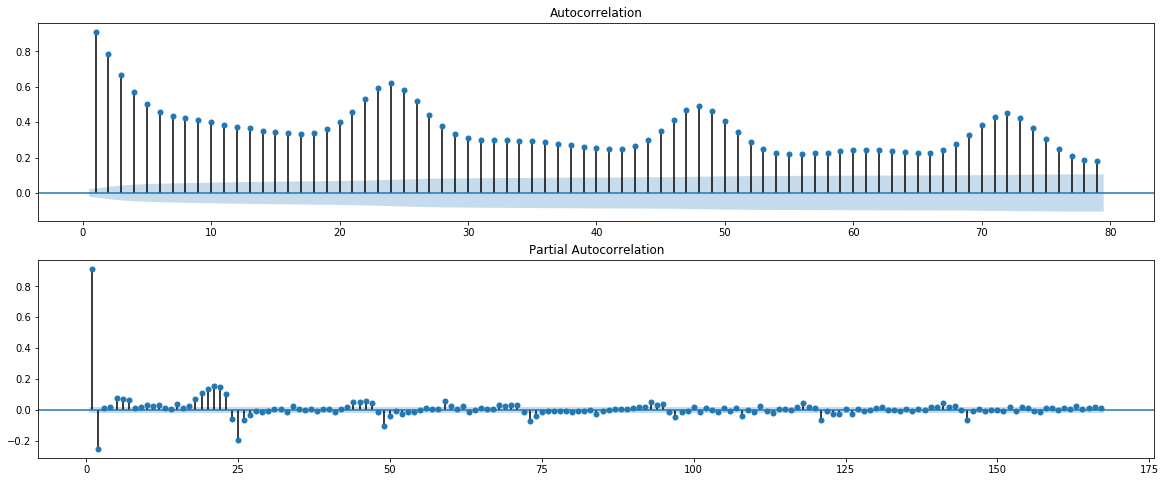

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=[20,8])
plt.subplot(211)
plot_acf(dx['NOx(GT)'].values, ax=plt.gca(),lags=range(1,80))
plt.subplot(212)
plot_pacf(dx['NOx(GT)'].values, ax=plt.gca(),lags=range(1,168))
plt.show()

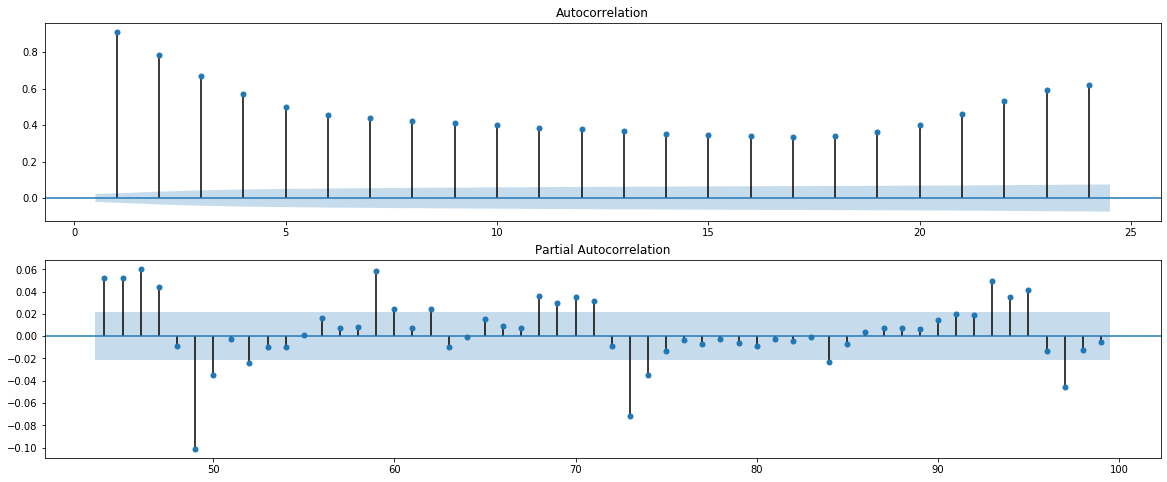

In [5]:
plt.figure(figsize=[20,8])
plt.subplot(211)
plot_acf(dx['NOx(GT)'].values, ax=plt.gca(),lags=range(1,25))
plt.subplot(212)
plot_pacf(dx['NOx(GT)'].values, ax=plt.gca(),lags=range(44
                                                        ,100))
plt.show()

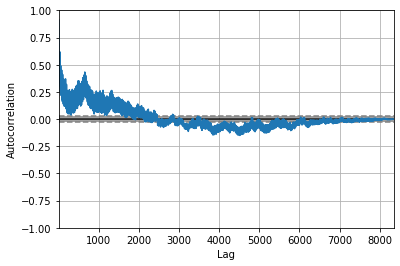

In [6]:

from pandas.plotting import autocorrelation_plot,lag_plot
autocorrelation_plot(dx['NOx(GT)'])

In [7]:
dx['shift-1']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=1)
dx['shift-2']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=2)
dx['shift-5']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=5)
#dx['shift-3']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=3)
dx['shift-6']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=6)
dx['shift-7']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=7)
#dx['shift-9']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=9)
dx['shift-10']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=10)
dx['shift-12']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=12)
#dx['shift-13']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=13)
#dx['shift-14']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=14)
dx['shift-15']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=15)
#dx['shift-16']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=16)
dx['shift-17']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=17)
dx['shift-18']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=18)
dx['shift-19']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=19)
dx['shift-20']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=20)
dx['shift-21']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=21)
dx['shift-22']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=22)
dx['shift-23']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=23)
dx['shift-24']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=24)
dx['shift-25']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=25)
dx['shift-26']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=26)
dx['shift-27']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=27)
dx['shift-44']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=44)
dx['shift-45']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=45)
dx['shift-46']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=46)
dx['shift-47']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=47)
#dx['shift-48']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=48)
dx['shift-49']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=49)
dx['shift-50']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=50)
dx['shift-59']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=59)
dx['shift-68']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=68)
dx['shift-69']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=69)
dx['shift-70']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=70)
dx['shift-71']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=71)
dx['shift-73']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=73)
dx['shift-74']=dx['NOx(GT)'].loc[:'2005-3-1'].shift(periods=73)
#dx['shift-145']=dx['T'].loc[:'2005-3-1'].shift(periods=145)



In [8]:
train=dx.loc[:'2005-3-1'].copy(deep=True)
train.dropna(inplace=True)
test=dx.loc['2005-3-2':].copy(deep=True)

In [9]:
train.columns

Index(['Month', 'Quarter', 'Dayofweek', 'HourofDay', 'DayofMonth',
       'Dayoftheyear', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'RH', 'AH', 'T', 'NOx(GT)', 'shift-1', 'shift-2',
       'shift-5', 'shift-6', 'shift-7', 'shift-10', 'shift-12', 'shift-15',
       'shift-17', 'shift-18', 'shift-19', 'shift-20', 'shift-21', 'shift-22',
       'shift-23', 'shift-24', 'shift-25', 'shift-26', 'shift-27', 'shift-44',
       'shift-45', 'shift-46', 'shift-47', 'shift-49', 'shift-50', 'shift-59',
       'shift-68', 'shift-69', 'shift-70', 'shift-71', 'shift-73', 'shift-74'],
      dtype='object')

In [50]:
#attb=['rolling-72','rolling-48','rolling-24','rolling-12']
attb=[ 'RH','AH','T',
    'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
      ,'shift-2','shift-5','shift-6','shift-7','shift-10','shift-12','shift-15','shift-18',
      'shift-19','shift-20','shift-21','shift-22','shift-23','shift-24','shift-25','shift-26',
      'shift-27','shift-44','shift-45','shift-46','shift-47','shift-49','shift-50','shift-59',
      'shift-68','shift-69','shift-70','shift-71','shift-73','shift-74'
     ]
RM = lm.LinearRegression()
#RM.fit(train[attb],train['NOx(GT)'])
RM.fit(train[attb].loc['2005-2-24':],train['NOx(GT)'].loc['2005-2-24':])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
test.index.size

615

In [52]:
window=train['NOx(GT)'].loc["2005-2-20":].values.tolist()
window[-12:]
dta_lst=[]
ctr=0
for x in test.index:
    lst=[test['RH'].loc[x],test['AH'].loc[x],test['T'].loc[x],
        #test['Month'].loc[x],
         #test['DayofMonth'].loc[x],
         test['HourofDay'].loc[x],test['Monday'].loc[x],
         test['Tuesday'].loc[x],test['Wednesday'].loc[x],test['Thursday'].loc[x],
         test['Friday'].loc[x],test['Saturday'].loc[x],test['Sunday'].loc[x],
        window[-1],window[-2],window[-5],window[-6],window[-7],window[-10],window[-12],window[-15],window[-18],
         window[-19],window[-20],window[-21],window[-22],window[-23],window[-24],window[-25],
         window[-26],window[-27],window[-44],window[-45],window[-46],window[-47],window[-49],
         window[-50],window[-59],window[-68],window[-69],window[-70],window[-71],window[-73],
         window[-74]
        ]
    
    pred=RM.predict(np.asarray([lst]).reshape(1,-42))
    window.append(pred[0])
    lst.append(pred[0])
    dta_lst.append(lst)

#train['T'].loc["2005-2-27":]

In [53]:
collist=[ 'RH','AH','T',
    'HourofDay',
        'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
         ,'shift-2','shift-5','shift-6','shift-7','shift-10','shift-12','shift-15','shift-18',
      'shift-19','shift-20','shift-21','shift-22','shift-23','shift-24','shift-25','shift-26',
      'shift-27','shift-44','shift-45','shift-46','shift-47','shift-49','shift-50','shift-59',
      'shift-68','shift-69','shift-70','shift-71','shift-73','shift-74',
         'Prediction']
prediction=pd.DataFrame(dta_lst,columns=collist,dtype='float')
prediction.index=test.index

In [54]:
test['shift-1']=prediction['shift-1'].copy(deep=True)
test['shift-2']=prediction['shift-2'].copy(deep=True)
#test['shift-3']=prediction['shift-3'].copy(deep=True)
test['Prediction']=prediction['Prediction'].copy(deep=True)

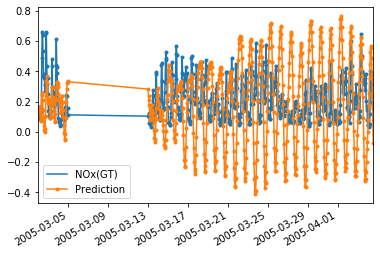

In [55]:
fig, ax = plt.subplots()
#finding trend using rolling window operation
test.plot(y='NOx(GT)',ax=ax,style='.-')
test.plot(y='Prediction',ax=ax,style='.-')



In [56]:
test[['NOx(GT)','Prediction']].loc['2005-3-2':'2005-3-3']


,NOx(GT),Prediction
2005-03-02 00:00:00,0.161356,0.159827
2005-03-02 01:00:00,0.161356,0.164019
2005-03-02 02:00:00,0.127458,0.137327
2005-03-02 03:00:00,0.107797,0.149417
2005-03-02 04:00:00,0.088136,0.117571
2005-03-02 05:00:00,0.093559,0.068707
2005-03-02 06:00:00,0.128814,0.076009
2005-03-02 07:00:00,0.143729,0.157698
2005-03-02 08:00:00,0.490847,0.245482
2005-03-02 09:00:00,0.658305,0.259660


In [57]:
mean_squared_error(test['NOx(GT)'].loc['2005-3-2':'2005-3-8'], test['Prediction'].loc['2005-3-2':'2005-3-8'])

0.028640585026781067

In [58]:
mean_squared_error(test['NOx(GT)'], test['Prediction'])

0.10804798210873519

In [59]:
r2_score(test['NOx(GT)'].loc['2005-3-2':'2005-3-8'], test['Prediction'].loc['2005-3-2':'2005-3-8'])

-0.04262327013987899

In [60]:
r2_score(test['NOx(GT)'], test['Prediction'])

-5.293947912979451

In [61]:
from fbprophet import Prophet


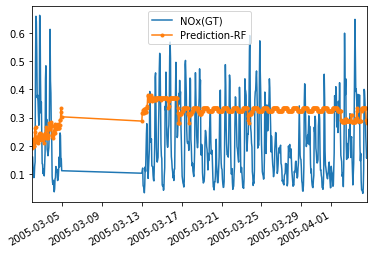

In [65]:
attb=[ 'RH','AH','T',
    'HourofDay',
        #'Monday', 'Tuesday', 'Wednesday',
       #'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
      ,'shift-2','shift-5','shift-6','shift-7','shift-10','shift-12','shift-15','shift-18',
      'shift-19','shift-20','shift-21','shift-22','shift-23','shift-24','shift-25','shift-26',
      'shift-27','shift-44','shift-45','shift-46','shift-47','shift-49','shift-50','shift-59',
      'shift-68','shift-69','shift-70','shift-71','shift-73','shift-74'
     ]
reg2 = RandomForestRegressor(random_state=1, n_estimators=10,max_depth=10,
                             min_samples_leaf=3,min_samples_split=2)
reg2.fit(train[attb].loc['2005-2-22':],train['NOx(GT)'].loc['2005-2-22':])
window=train['NOx(GT)'].values.tolist()
window[-12:]
dta_lst=[]
ctr=0
for x in test.index:
    lst=[test['RH'].loc[x],test['AH'].loc[x],test['T'].loc[x],
        #test['Month'].loc[x],
         #test['DayofMonth'].loc[x],
         test['HourofDay'].loc[x],
         #test['Monday'].loc[x],
         #test['Tuesday'].loc[x],test['Wednesday'].loc[x],test['Thursday'].loc[x],
         #test['Friday'].loc[x],test['Saturday'].loc[x],test['Sunday'].loc[x],
         window[-1],window[-2],window[-5],window[-6],window[-7],window[-10],window[-12],window[-15],window[-18],
         window[-19],window[-20],window[-21],window[-22],window[-23],window[-24],window[-25],
         window[-26],window[-27],window[-44],window[-45],window[-46],window[-47],window[-49],
         window[-50],window[-59],window[-68],window[-69],window[-70],window[-71],window[-73],
         window[-74]
        ]
    
    pred=reg2.predict(np.asarray([lst]).reshape(1,-42))
    window.append(pred[0])
    lst.append(pred[0])
    dta_lst.append(lst)

collist=[ 'RH','AH','T',
    'HourofDay',
        #'Monday', 'Tuesday', 'Wednesday',
       #'Thursday', 'Friday', 'Saturday', 'Sunday',
    'shift-1'
         ,'shift-2','shift-5','shift-6','shift-7','shift-10','shift-12','shift-15','shift-18',
      'shift-19','shift-20','shift-21','shift-22','shift-23','shift-24','shift-25','shift-26',
      'shift-27','shift-44','shift-45','shift-46','shift-47','shift-49','shift-50','shift-59',
      'shift-68','shift-69','shift-70','shift-71','shift-73','shift-74',
         'Prediction']
prediction=pd.DataFrame(dta_lst,columns=collist,dtype='float')
prediction.index=test.index
test['Prediction-RF']=prediction['Prediction'].copy(deep=True)

fig, ax = plt.subplots()
#finding trend using rolling window operation
test.plot(y='NOx(GT)',ax=ax)
test.plot(y='Prediction-RF',ax=ax,style='.-')

In [66]:
mean_squared_error(test['NOx(GT)'].loc['2005-3-2':'2005-3-2'], test['Prediction-RF'].loc['2005-3-2':'2005-3-2'])

0.04422754588526598

In [67]:
r2_score(test['NOx(GT)'].loc['2005-3-2':'2005-3-2'], test['Prediction-RF'].loc['2005-3-2':'2005-3-2'])

-0.25043670379985605

In [68]:
test[['NOx(GT)','Prediction','Prediction-RF']].loc['2005-3-2':'2005-3-3']

,NOx(GT),Prediction,Prediction-RF
2005-03-02 00:00:00,0.161356,0.159827,0.192246
2005-03-02 01:00:00,0.161356,0.164019,0.208730
2005-03-02 02:00:00,0.127458,0.137327,0.225054
2005-03-02 03:00:00,0.107797,0.149417,0.197708
2005-03-02 04:00:00,0.088136,0.117571,0.198210
2005-03-02 05:00:00,0.093559,0.068707,0.199122
2005-03-02 06:00:00,0.128814,0.076009,0.248867
2005-03-02 07:00:00,0.143729,0.157698,0.265267
2005-03-02 08:00:00,0.490847,0.245482,0.266553
2005-03-02 09:00:00,0.658305,0.259660,0.232260


In [25]:
pred = RM.predict(test[attb])
pred=pd.DataFrame(pred,columns=['Prediction'])
pred.index=test.index
test1=pd.concat([test,pred],axis=1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
fig, ax = plt.subplots()
#finding trend using rolling window operation
dx.plot(y='T',ax=ax)
test1.plot(y='Prediction',ax=ax)
dx.plot(y='T')

In [ ]:
mean_squared_error(test1['T'], test1['Prediction'])

In [ ]:
r2_score(test1['T'], test1['Prediction'])

In [ ]:
reg2 = RandomForestRegressor(random_state=1, n_estimators=100,max_depth=30,min_samples_leaf=3,min_samples_split=5)
reg2.fit(train[attb],train['T'])
pred = reg2.predict(test[attb])
pred=pd.DataFrame(pred,columns=['Prediction'])
pred.index=test.index
test1=pd.concat([test,pred],axis=1)
fig, ax = plt.subplots()
#finding trend using rolling window operation
dx.plot(y='T',ax=ax)
test1.plot(y='Prediction',ax=ax)
dx.plot(y='T')

In [ ]:
mean_squared_error(test1['T'], test1['Prediction'])


In [ ]:
r2_score(test1['T'], test1['Prediction'])